# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use SFrames to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Let's get started!

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

# Load LendingClub dataset

In [2]:
loans = pd.read_csv("lending-club-data.csv")

/Users/amitpatel/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [4]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [5]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
del loans['bad_loans']

In [6]:
loans.groupby(['safe_loans']).count()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
safe_loans,,,,,,,,,,,,,,,,,,,,,
-1,23150,23150,23150,23150,23150,23150,23150,23150,23150,23150,...,23150,23147,23147,23122,23150,23150,23150,23150,23150,23150
1,99457,99457,99457,99457,99457,99457,99457,99457,99457,99457,...,99457,99431,99431,99340,99457,99453,99457,99457,99457,99457


In [7]:
99457/(99457 + 23150)

0.8111853319957262

## Features for the classification algorithm

In [8]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

In [9]:
loans.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.00,-1
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00,1
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97,1
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00,1


What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook. 

In [10]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print("Number of safe loans  : %s" % len(safe_loans_raw))
print("Number of risky loans : %s" % len(risky_loans_raw))

Number of safe loans  : 99457
Number of risky loans : 23150


Then follow the following steps:

Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. Alternatively, see #7 for implementation hints.
Load the JSON files into the lists train_idx and validation_idx.
Perform train/validation split using train_idx and validation_idx.

## One hot encoding

In [119]:

# Get  columns whose data type is object i.e. string
filteredColumns = loans.dtypes[loans.dtypes == np.object]
 
# list of columns whose data type is object i.e. string
categorical_variables = list(filteredColumns.index)

# One-hot encoding and removing the categorical columns
loans_data = loans
# for feature in categorical_variables:
#     loans_data = pd.get_dummies(loans_data, prefix = [feature], columns = [feature])
loans_data = pd.get_dummies(loans_data)

In [147]:
loans_data.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,11,27.65,1,1,83.7,0.00,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.00,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,11,8.72,1,1,98.5,0.00,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,11,20.00,0,1,21.0,16.97,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,4,11.20,1,1,28.3,0.00,1,1,0,...,0,0,0,0,0,0,0,1,1,0


In [149]:
loans_data.tail()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
122602,1,0,1.50,0,0,14.6,0.0,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
122603,0,11,11.26,0,0,15.2,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
122604,0,6,12.28,0,0,10.7,0.0,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
122605,0,11,18.45,1,1,46.3,0.0,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
122606,0,4,5.39,0,1,21.5,0.0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [148]:
loans_data.shape

(122607, 68)

## Split data into training and validation sets

In [121]:
!ls

CLA05-NB01.ipynb
Classification Assignment Week 3.ipynb
KVt5YeI3Eem3eBKX1RzcIA_74f9a84fb5e945d484f2ff09f5d532e6_CLA05-NB01.ipynb.zip
KVugjOI3Eemx8A5HK6Ls8g_4ae1e7ce863a4049b4ab5da425c6bd7a_lending-club-data.sframe.zip
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-5-assignment-1-train-idx.json.zip
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-5-assignment-1-validation-idx.json.zip
_c18ade74fb45f307917ac9c670944b84_lending-club-data.csv.zip
decision-trees-annotated.pdf
decision_tree_model.png
diabetes.png
lending-club-data.csv
lending-club-data.sframe
module-5-assignment-1-train-idx.json
module-5-assignment-1-validation-idx.json
small_model.png


In [122]:
# Read the index for the train data
with open('module-5-assignment-1-train-idx.json', 'r') as filehandle:
    train_index = json.load(filehandle)

In [123]:
train_data = loans_data.iloc[train_index]

In [124]:
train_data.shape

(37224, 68)

In [125]:
# Read the index for the train data
with open('module-5-assignment-1-validation-idx.json', 'r') as filehandle:
    validation_index = json.load(filehandle)

In [126]:
validation_data = loans_data.iloc[validation_index]

In [127]:
validation_data.shape

(9284, 68)

# Use decision tree to build a classifier

 Now, let's use the built-in scikit learn decision tree learner (sklearn.tree.DecisionTreeClassifier) to create a loan prediction model on the training data. To do this, you will need to import sklearn, sklearn.tree, and numpy.

Note: You will have to first convert the SFrame into a numpy data matrix, and extract the target labels as a numpy array (Hint: you can use the .to_numpy() method call on SFrame to turn SFrames into numpy arrays). See the API for more information. Make sure to set max_depth=6.

Call this model decision_tree_model.

In [128]:
# Create Decision Tree classifer object
decision_tree_model = DecisionTreeClassifier(max_depth = 6)

In [150]:
loans_data.columns

Index(['short_emp', 'emp_length_num', 'dti', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee',
       'safe_loans', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
       'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
       'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
       'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
       'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
       'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
       'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card'

In [151]:
# Train Decision Tree Classifer
decision_tree_model = decision_tree_model.fit(train_data.drop('safe_loans',1),train_data[target])

## Visualizing a learned model

In [154]:
# Taking the columns of the dataframe after the hot-one encoding
new_features = loans_data.drop('safe_loans',1).columns

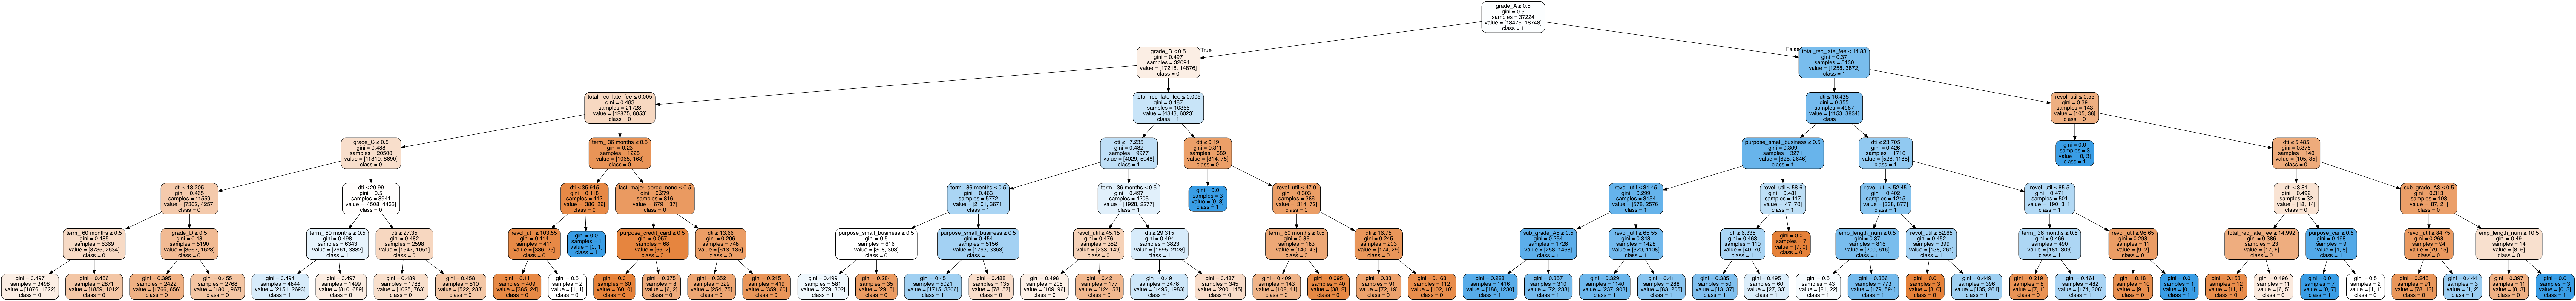

In [155]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

dot_data = StringIO()
export_graphviz(decision_tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = new_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree_model.png')
Image(graph.create_png())

Also train a tree using with max_depth=2. Call this model small_model.

In [156]:
small_model = DecisionTreeClassifier(max_depth = 2)

In [157]:
small_model = small_model.fit(train_data[new_features],train_data[target])

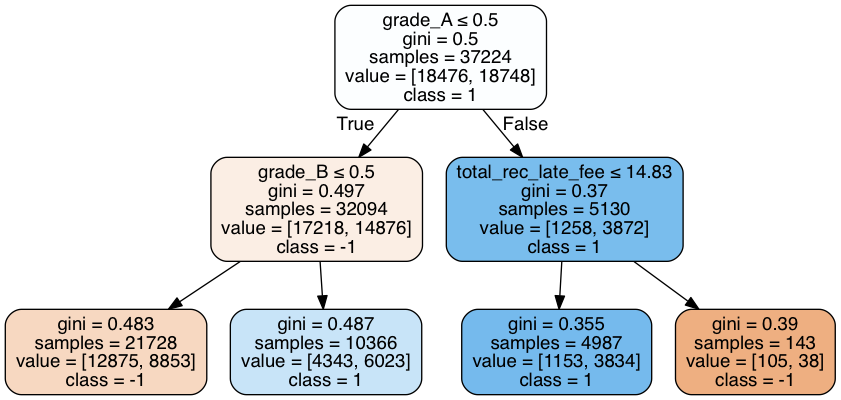

In [158]:

dot_data = StringIO()
export_graphviz(small_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = new_features,class_names=['-1','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('small_model.png')
Image(graph.create_png())

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [159]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
79,0,10,16.85,1,1,96.4,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
24,0,3,13.97,0,1,59.5,0.0,-1,0,0,...,0,0,0,0,1,0,0,0,0,1
41,0,11,16.33,1,1,62.1,0.0,-1,1,0,...,0,0,0,0,0,0,0,0,1,0


## Explore label predictions

Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. 

**Hint:** Be sure to use the `.predict()` method.

In [160]:
sample_predictions = decision_tree_model.predict(sample_validation_data[new_features])

In [161]:
sample_predictions

array([ 1, -1, -1,  1])

In [162]:
sample_validation_data['safe_loans']

19    1
79    1
24   -1
41   -1
Name: safe_loans, dtype: int64

**Quiz Question:** What percentage of the predictions on `sample_validation_data` did `decision_tree_model` get correct?

In [163]:
predictions_percentage = (sample_predictions == np.array(sample_validation_data['safe_loans'])).sum()/len(sample_predictions)

In [164]:
predictions_percentage

0.5

## Explore probability predictions

For each row in the sample_validation_data, what is the probability (according decision_tree_model) of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

**Quiz Question:** Which loan has the highest probability of being classified as a safe loan?

**Checkpoint:** Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?

In [165]:
sample_predicted_proba = decision_tree_model.predict_proba(sample_validation_data[new_features])

In [166]:
sample_predicted_proba

array([[0.34156543, 0.65843457],
       [0.53630646, 0.46369354],
       [0.64750958, 0.35249042],
       [0.20789474, 0.79210526]])

## Tricky predictions!

Now, we will explore something pretty interesting. For each row in the sample_validation_data, what is the probability (according to small_model) of a loan being classified as safe?

** Quiz Question:** Notice that the probability preditions are the exact same for the 2nd and 3rd loans. Why would this happen?

In [167]:
sample_predicted_proba_small = small_model.predict_proba(sample_validation_data[new_features])

In [168]:
sample_predicted_proba_small

array([[0.41896585, 0.58103415],
       [0.59255339, 0.40744661],
       [0.59255339, 0.40744661],
       [0.23120112, 0.76879888]])

## Visualize the prediction on a tree
Note that you should be able to look at the small tree (of depth 2), traverse it yourself, and visualize the prediction being made. Consider the following point in the sample_validation_data:

In [169]:
sample_validation_data[['grade_D','term_ 60 months']]

,grade_D,term_ 60 months
19,0,0
79,1,0
24,1,1
41,0,0


In [170]:
sample_predictions_small = small_model.predict(sample_validation_data[new_features])

In [171]:
sample_predictions_small

array([ 1, -1, -1,  1])

If you have Graphviz, go ahead and re-visualize small_model here to do the traversing for this data point.

** Quiz Question:** Based on the visualized tree, what prediction would you make for this data point (according to small_model)? (If you don't have Graphviz, you can answer this quiz question by executing the next part.)

# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

Evaluate the accuracy of small_model and decision_tree_model on the training data. (Hint: if you are using scikit-learn, you can use the .score() method)

**Checkpoint:** You should see that the small_model performs worse than the decision_tree_model on the training data.

In [172]:
accuracy_decision_tree_model = decision_tree_model.score(train_data[new_features], train_data[target])

In [173]:
print("Accuracy of the decision_tree_model on training data =" ,accuracy_decision_tree_model)

Accuracy of the decision_tree_model on training data = 0.6405276165914464


In [174]:
accuracy_small_model = small_model.score(train_data[new_features], train_data[target])

In [175]:
print("Accuracy of the small_model on training data =",accuracy_small_model)

Accuracy of the small_model on training data = 0.6135020416935311


Now, evaluate the accuracy of the small_model and decision_tree_model on the entire validation_data, not just the subsample considered above.

**Quiz Question:** What is the accuracy of decision_tree_model on the validation set, rounded to the nearest .01?

In [176]:
accuracy_validation_decision_tree_model = decision_tree_model.score(validation_data[new_features], 
                                                                    validation_data[target])

In [177]:
print("Accuracy of the decision_tree_model on validation data =" ,accuracy_validation_decision_tree_model)

Accuracy of the decision_tree_model on validation data = 0.6363636363636364


In [178]:
accuracy_validation_small_model = small_model.score(validation_data[new_features], 
                                                                    validation_data[target])

In [179]:
print("Accuracy of the small_model on validation data =" ,accuracy_validation_small_model)

Accuracy of the small_model on validation data = 0.6193451098664369


## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [180]:
big_model = DecisionTreeClassifier(max_depth = 10)
big_model = big_model.fit(train_data[new_features],train_data[target])

Now, let us evaluate **big_model** on the training set and validation set.

In [181]:
accuracy_big_model_train = big_model.score(train_data[new_features], 
                                                                    train_data[target])

In [182]:
accuracy_big_model_validation = big_model.score(validation_data[new_features], 
                                                                    validation_data[target])

In [183]:
print("Accuracy of the big model on training data = ",accuracy_big_model_train)
print("Accuracy of the big model on validation data = ",accuracy_big_model_validation)


Accuracy of the big model on training data =  0.6638459058671825
Accuracy of the big model on validation data =  0.6268849633778544


**Checkpoint:** We should see that **big_model** has even better performance on the training set than **decision_tree_model** did on the training set.

**Quiz Question:** How does the performance of **big_model** on the validation set compare to **decision_tree_model** on the validation set? Is this a sign of overfitting?

### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

First, let us make predictions on `validation_data` using the `decision_tree_model`:

In [184]:
predictions_decision_tree_model_validation = decision_tree_model.predict(validation_data[new_features])

**False positives** are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives:

In [185]:
false_positives_count = sum( (predictions_decision_tree_model_validation == +1) &
                           (np.array(validation_data[target]) == -1))

In [186]:
false_positives_count

1661

**False negatives** are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

In [187]:
false_negatives_count = sum( (predictions_decision_tree_model_validation == -1) &
                           (np.array(validation_data[target]) == +1))

In [188]:
false_negatives_count

1715

**Quiz Question:** Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

What is the total cost of mistakes made by `decision_tree_model` on `validation_data`?

In [189]:
total_cost = (false_positives_count * 20000) + (false_negatives_count * 10000)

In [190]:
print("Total cost=", total_cost)

Total cost= 50370000
